<a href="https://colab.research.google.com/github/lisabroadhead/store-vender-forecast/blob/main/ML_part_2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sale's Vendor Forecast - Machine Learning
Lisa Broadhead <br/>
June 29, 2022<br/>

In [83]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import set_config
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
set_config(display='diagram')

In [2]:
file = "/content/drive/MyDrive/Colab Notebooks/coding_dojo/Data Science/files/sales_predictions (1).csv"

df = pd.read_csv(file)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Basic Checks and cleanup

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [4]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
# Item_Fat_Content
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'low fat': 'Low Fat', 'LF': 'Low Fat','reg': 'Regular'})

In [7]:
# Outlet_Location_Type
df['Outlet_Location_Type'] = df['Outlet_Location_Type'].replace({'Tier 1': 1, 'Tier 2': 2, 'Tier 3': 3})
df['Outlet_Location_Type'].unique()

array([1, 3, 2])

### Ordinal Encoding

In [8]:
# Outlet_Size
df['Outlet_Size'] = df['Outlet_Size'].fillna(0)
df['Outlet_Size'].replace({'Small': 1, 'Medium': 2, 'High': 3 }, inplace=True)
df['Outlet_Size'].unique()

array([2, 0, 3, 1])

In [9]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,2,1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,2,3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,2,1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,0,3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,3,3,Supermarket Type1,994.7052


### Drop Unecessary Columns

In [10]:
# Item_Identifier / Outlet_Identifier - unique IDs, droppped due to how many variations
df.drop(columns={'Item_Identifier', 'Outlet_Identifier'}, inplace=True)

In [11]:
df['Item_Type'].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

### Validation and Train Split

In [12]:
y = df['Item_Outlet_Sales']
X = df.drop(columns='Item_Outlet_Sales')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# len(X_train), len(X_test), len(y_train), len(y_test)

### Preprocessing

In [13]:
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

In [14]:
mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')

scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [15]:
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [16]:
cat_pipe = make_pipeline(freq_imputer, ohe)
cat_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [17]:
num_tuple = (numeric_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

preprocessor = make_column_transformer(num_tuple, cat_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f567a8905d0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f567a890e50>)])

In [18]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f567a8905d0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f567a890e50>)])

In [19]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed

array([[ 0.81724868, -0.71277507,  1.82810922, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.5563395 , -1.29105225,  0.60336888, ...,  0.        ,
         1.        ,  0.        ],
       [-0.13151196,  1.81331864,  0.24454056, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.11373638, -0.92052713,  1.52302674, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.76600931, -0.2277552 , -0.38377708, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.81724868, -0.95867683, -0.73836105, ...,  1.        ,
         0.        ,  0.        ]])

## Regression Models

The goal of this is to help the retailer understand the properties of products and outlets that play crucial roles in predicting sales.

#### 1. Your first task is to build a linear regression model to predict sales.
- Build a linear regression model.

In [20]:
reg = LinearRegression()

In [21]:
lin_reg_pipe = make_pipeline(preprocessor, reg)

In [22]:
lin_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f567a8905d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f567a890e50>)])),
                ('linearregression', LinearRegression())])

In [23]:
predictions = lin_reg_pipe.predict(X_test)

In [24]:
train_preds = lin_reg_pipe.predict(X_train)
test_preds = lin_reg_pipe.predict(X_test)

##### Compare the performance of your model based on r^2.

In [26]:
##### Shows that our model is only right 50% of the time

##### Compare the performance of your model based on rmse.  

In [27]:
# MAE
train_MAE = mean_absolute_error(y_train, train_preds)
test_MAE = mean_absolute_error(y_test, test_preds)

print(train_MAE)
print(test_MAE)

847.3235466185345
804.3111922625977


In [28]:
# MSE
train_MSE = mean_squared_error(y_train, train_preds)
test_MSE = mean_squared_error(y_test, test_preds)

print(train_MSE)
print(test_MSE)

1298504.7391600292
1195872.186288277


In [29]:
# RSME
train_RSME = np.sqrt(train_MSE)
test_RSME = np.sqrt(test_MSE)

print(train_RSME)
print(test_RSME)

1139.5195211842706
1093.5594114122364


In [211]:
# R2
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print(train_r2)
print(test_r2)

1.0
0.20243187303055876


In [30]:
##### Shows that our larger values are really getting punished. Thats why the R2 test score is down and why there's such a big gap in the RSME data.

#### 2. Your second task is to build a regression tree model to predict sales.
- Build a simple regression tree model.

In [31]:
dec_tree = DecisionTreeRegressor(random_state=42)

In [32]:
dec_tree.fit(X_train_processed, y_train)

DecisionTreeRegressor(random_state=42)

In [33]:
train_preds = dec_tree.predict(X_train_processed)
test_preds = dec_tree.predict(X_test_processed)

In [34]:
dec_tree.get_depth()

40

In [35]:
# List of values to try for max_depth:
depths = list(range(2, 35)) # will try every value between 2 and 36
# Data frame to store the score for each value of max_depth:
scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dec_tree.fit(X_train_processed, y_train)
    train_score = dec_tree.score(X_test_processed, y_test)
    test_score = dec_tree.score(X_test_processed, y_test)
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score

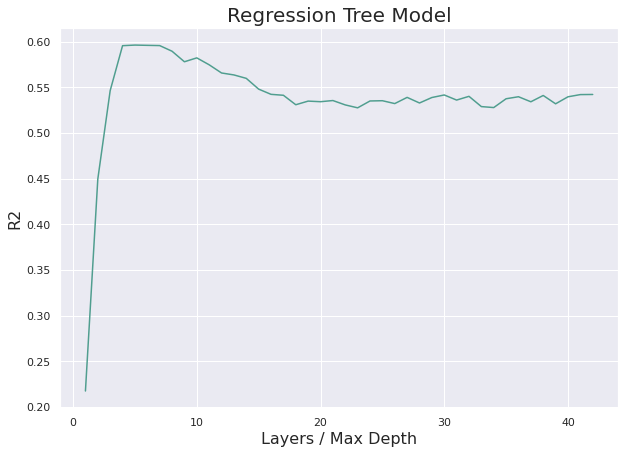

In [100]:
sns.set_style("darkgrid")

plt.figure(figsize=(10,7))
plt.plot(depths, scores['Test Score'], color='#509E8F')
plt.title("Regression Tree Model", fontsize=20)
plt.xlabel('Layers / Max Depth', fontsize=16)
plt.ylabel('R2', fontsize=16);


In [37]:
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

,Test Score,Train Score
5,0.59471,0.59471
4,0.584005,0.584005
6,0.582587,0.582587
7,0.576807,0.576807
8,0.562076,0.562076


##### Compare
- Model based on r^2.
- Model based on rmse. 

------

So our regression tree at a dpeth of 5 is doing only slightly better then our RSME

#### Bagged Trees

In [233]:
bagreg = BaggingRegressor(random_state = 42)

In [234]:
bagreg.fit(X_train_processed, y_train)

BaggingRegressor(random_state=42)

In [235]:
# List of estimator values
estimators = [10, 20, 30, 40, 50, 100]
# Data frame to store the scores
scores = pd.DataFrame(index=estimators, columns=['Train Score', 'Test Score'])
# Iterate through the values to find the best number of estimators
for num_estimators in estimators:
   bag_reg = BaggingRegressor(n_estimators=num_estimators, random_state=42)
   bag_reg.fit(X_train_processed, y_train)
   train_score = bag_reg.score(X_train_processed, y_train)
   test_score = bag_reg.score(X_test_processed, y_test)
   scores.loc[num_estimators, 'Train Score'] = train_score
   scores.loc[num_estimators, 'Test Score'] = test_score


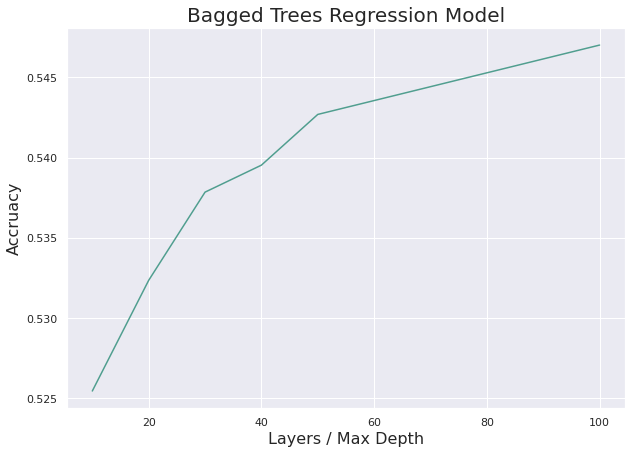

In [236]:
sns.set_style("darkgrid")

plt.figure(figsize=(10,7))
plt.plot(scores['Test Score'], color='#509E8F')
plt.title("Bagged Trees Regression Model", fontsize=20)
plt.xlabel("Layers / Max Depth", fontsize=16)
plt.ylabel("Accruacy", fontsize=16)
plt.show()

In [237]:
scores = scores.sort_values(by='Test Score', ascending=False)
scores

,Train Score,Test Score
100,0.937946,0.547001
50,0.935236,0.542684
40,0.933633,0.539526
30,0.931509,0.537846
20,0.927606,0.532354
10,0.919918,0.525464


#### Random Forests

In [238]:
rf = RandomForestRegressor(random_state = 42)

In [239]:
rf.fit(X_train_processed, y_train)

RandomForestRegressor(random_state=42)

In [240]:
rf.predict(X_test_processed)

array([ 742.593372,  920.708188,  832.01697 , ..., 4093.924304,
       2051.86244 , 2093.14204 ])

In [241]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [46]:
est_depths = [estimator.get_depth() for estimator in rf.estimators_]
max(est_depths)

43

In [230]:
depths = range(1, max(est_depths))
scores = pd.DataFrame(index=depths, columns=['Test Score'])
for depth in depths:    
   model = RandomForestRegressor(max_depth=depth, max_leaf_nodes=43, warm_start=True,oob_score=True)
   model.fit(X_train_processed, y_train)
   scores.loc[depth, 'Train Score'] = model.score(X_train_processed, y_train)
   scores.loc[depth, 'Test Score'] = model.score(X_test_processed, y_test)
   scores.head()

In [225]:
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

,Test Score,Train Score
5,0.602578,0.610558
6,0.599854,0.623756
4,0.597641,0.596527
23,0.597151,0.648599
34,0.596604,0.649416


In [ ]:
# 0.603649	0.610753
# 0.603206	0.608036
# 0.600973	0.607083
# 0.604972	0.609472 - min_samples_leaf=5
# 0.604768	0.619890 - min_samples_leaf=10
# 0.604162	0.608537 - min_samples_leaf=15
# 0.603612	0.628804  -min_samples_leaf=43

0.602293	0.610734

In [ ]:
print(sorted_scores['id'])
print(sorted_scores['Train Score'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


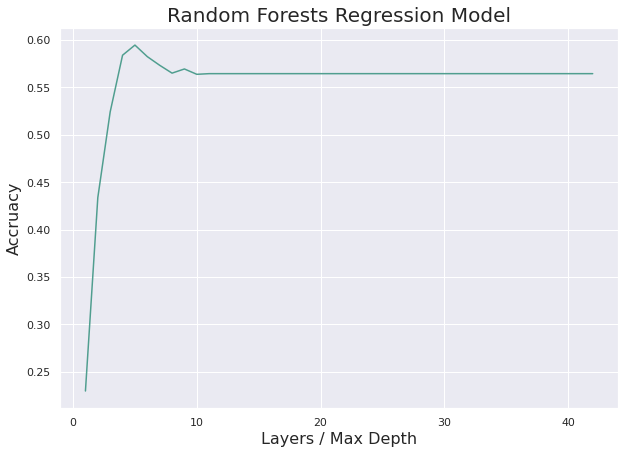

In [215]:
sns.set_style("darkgrid")
ax = fig.add_subplot(111)

plt.figure(figsize=(10,7))
plt.plot(scores['Test Score'], color='#509E8F')
plt.title("Random Forests Regression Model", fontsize=20)
plt.xlabel("Layers / Max Depth", fontsize=16)
plt.ylabel("Accruacy", fontsize=16)

plt.show()

In [50]:
##### This one is slightly better but the testing data is still wrong 50% of the time

#### 3. You now have tried 2 different models on your data set. You need to determine which model to implement.
- Overall, which model do you recommend & Justify your recommendation.
<br/>
-----
<br/>
Even though Decision Tree got a lsightly hight value overall, its still a very low number. If I had to pick Desicion Tree because there are more vlaues we can use to dial in the model to predict better number. 

3. read me file
4. ask TA or instructor about your assigments and make sure you're on the right track